In [19]:
import numpy as np
import pandas as pd

from sklearn.model_selection import train_test_split, RandomizedSearchCV
import xgboost as xgb
from sklearn.metrics import confusion_matrix, roc_auc_score, accuracy_score
import pickle

import time

import matplotlib.pyplot as plt
%matplotlib inline

## Modeling

This project utilizes the extreme gradient boost (XGBoost) model to predict a borrower's loan status. Since this label is a binary variable, it is appropriate to use the classification method of this model. The metric used to measure the model performance is the 'ROC-AUC' score; this metric is more suitable compared to accuracy score due to the imbalance of the proportion of the loan statuses. 

The XGBoost model utilizes an ensemble of decision trees to minimize the loss function. Boosting refers to a technique built by each ensemble tree with the weak learner(s). By combining the different weak learners, this model converts them into strong ones and, at the same time, reduces bias and variance in the model. Next, this model utilizes the second order of the Taylor polynomial combined with regularization to calculate the output of each leaf. Lastly, the prediction is updated by adding the previous prediction by the output multiplied by the learning rate.

XGBoost utilizes a "Basic Exact Greedy" algorithm to determine the split of each tree node; the value to quantify this is called "Gain."  This algorithm starts with a single leaf and recursively adds branches by finding the maximum gain of each split. For the first iteration of the model, the initial prediction is made by initiating a constant value. Then, the gain is calculated by first calculating the weight of each leaf and the parent node. The weight is calculated by dividing the sum of the first-order derivative of the loss function(gradient) squared by the sum of the second-order derivative of the loss function(hessian) plus the lambda. This process is repeated until the maximum number of depths or if the minimum child weight is reached. Then, this model prunes each tree by subtracting the hyperparameter gamma from the gain of the lowest branch. If this formula results in a negative number, this branch will be pruned, and this step is repeated. However, if the lowest branch is not pruned, the model will not prune the parent branches if their gain - gamma is negative.

Finally, each leaf's output(weights) is calculated by approximating the loss function using the second-order polynomial plus regularization. If the  $\lambda$ is set to 0, this model's object is the same as traditional gradient boosting. The prediction is updated by adding the previous prediction plus the learning rate multiplied by the leaf output. These steps conclude the one iteration of the model. The model will repeat these iterations until the maximum number of iterations or the early stopping rounds is reached.

Initialize model with a constant value: $f_{0}(x) = \textrm{arg min}_{\hat{y}} \sum \limits _{i=1} ^{N} L(y_{i}, \hat{y})$

Find the first and second order derivate of the Loss Function: $g_i = ∂\hat{y} (t−1) l(y_i, \hat{y}^{(t−1)})$ and $h_i = ∂^2 \hat{y}(t−1) l(y_i, \hat{y}^{(t−1)})$

Determine the split point by maximizing the gain: $L_{split} = \frac{1}{2}[\frac{(\sum_{i \in IL} g_i)^{2}}{\sum_{i \in IL} h_i + \lambda} + \frac{(\sum_{i \in IR} g_i)^{2}}{\sum_{i \in IR} h_i + \lambda} - \frac{(\sum_{i \in I} g_i)^{2}}{\sum_{i \in I} h_i + \lambda}] - \gamma$

###### - This step is repeated until the minimum child weight or the maximum depth is reached
###### - If the gain - $\gamma$ of the lowest branch is negative, this branch will be pruned and repeated for the parent branches. However, if this branch isn't pruned, the parent branch will not be pruned even if this is negative.

Once the tree is completed, the output(weight) value of each leaf is approximated with the second order of Taylor Polynomials, simplified to: $w_{j} = -\frac{\sum_{i \in I_{j}} g_i}{\sum_{i \in I_{j}} h_i + \lambda}$ 

The prediction is updated by adding the previous prediction plus the learning rate multiplied by the new output: $\hat{y}_{i}^{(t−1)} + \eta w_{i}^{t}$. 

These steps make up of one XGBoost iteration, this will repeat until the number of estimators or early stopping rounds' criterias have been met. These steps comprise one XGBoost iteration; this will repeat until the number of estimators or early stopping rounds' criteria has been met. This signifies the conclusion of the model's training, and the model can be used to make predictions. 

Lastly, I can plot the feature importances to determine which feature resulted in the highest gain value. This step is crucial to understanding the importance of each feature and providing stakeholders with essential information to make informed business decisions. 

Sources: [XGBoost White Paper](https://arxiv.org/pdf/1603.02754.pdf), [StatQuest XGBoost Breakdown](https://www.youtube.com/watch?v=OtD8wVaFm6E&ab_channel=StatQuestwithJoshStarmer)

In [2]:
def map_loan_status_to_binary(loanstatus):
    if loanstatus in ('Current', 'Completed', 'FinalPaymentInProgress'):
        return 0
    else:
        return 1

In [3]:
def clean_and_split(filename, test_size=0.25):
    '''
    Creates pandas df, creates label column, imputes missing values and creates training/testing data
    Args:
        filename (string - filepath to csv file) - filepath of the datafile, will then use pandas read_csv to create a df
        test_size (float) - percentage of data set aside for testing
    returns:
        X_train, X_test, y_train, y_test - four dataframes split with sklearn.model_selection.train_test_split based on the percentage of test_size
    '''
    
    import pandas as pd
    from sklearn.model_selection import train_test_split
    from sklearn.impute import SimpleImputer
    
    df = pd.read_csv(filename)
    # combine the two different credit grade columns
    df.loc[df['CreditGrade'].notnull(),'ProsperRating (Alpha)'] = df.loc[df['CreditGrade'].notnull(), 'CreditGrade']
    # convert loan status to binary
    df['binary_loan_status'] = df['LoanStatus'].apply(map_loan_status_to_binary)
    # Seperate into features and labels
    X = df.drop(columns='binary_loan_status')
    y = df['binary_loan_status']
    
    # Impute categorical columns with most frequent and numeric columns with mean values
    cat_columns = X.select_dtypes('object').columns
    num_columns = X.select_dtypes(include=np.number).columns
    
    cat_encoder = SimpleImputer(strategy='most_frequent')
    num_encoder = SimpleImputer()
    
    X[cat_columns] = cat_encoder.fit_transform(X[cat_columns])
    X[num_columns] = num_encoder.fit_transform(X[num_columns])
    
    # drop columns that are either unique identifiers or indicators of late/default loans
    X.drop(columns=['ListingKey', 'ListingNumber', 'LoanKey', 'GroupKey', 'MemberKey', 'ProsperRating (numeric)', 
                    'CreditGrade', 'LP_GrossPrincipalLoss', 'LoanCurrentDaysDelinquent', 'LP_NetPrincipalLoss', 
                    'LoanFirstDefaultedCycleNumber', 'LP_CollectionFees', 'LP_NonPrincipalRecoverypayments', 
                    'ClosedDate', 'LoanStatus', 'LoanOriginationQuarter', 'LoanNumber',
                    'FirstRecordedCreditLine', 'ListingCreationDate', 'DateCreditPulled', 'LoanOriginationDate'], inplace=True)
    
    # Transform categorical columns with dummy columns
    for col in X.select_dtypes('object').columns:
        X = pd.concat([X, pd.get_dummies(X[col], prefix=col)],  axis=1)
        del X[col]
    
    X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y, test_size=test_size)
    
    return X_train, X_test, y_train, y_test

In [4]:
def model_scores(y_actual, y_pred):
    from sklearn.metrics import confusion_matrix, roc_auc_score, accuracy_score
    cm = confusion_matrix(y_actual, y_pred)
    precision = cm[1][1]/(cm[1][1]+cm[1][0])
    recall = cm[1][1]/(cm[1][1]+cm[0][1])
    print('Model Results:')
    print('-------------------')
    print('Accuracy Score: ', accuracy_score(y_actual, y_pred))
    print('-------------------')
    print('ROC-AUC Score: ', roc_auc_score(y_actual, y_pred))
    print('-------------------')
    print('Confusion Matrix:')
    print(cm)
    print('-------------------')
    print('Precision: ', precision)
    print('-------------------')
    print('Recall: ',  recall)
    print('-------------------')
    print('F1: ', 2*(precision*recall)/(precision+recall))
   

In [5]:
filename = 'prosperLoanData.csv'

In [6]:
X_train, X_test, y_train, y_test = clean_and_split(filename)

## Initial Model

In [7]:
clf_xgb = xgb.XGBClassifier(objective='binary:logistic', seed=123, eval_metric='aucpr')
clf_xgb.fit(X_train, y_train, verbose=True,
           eval_set = [(X_train, y_train), (X_test, y_test)])

[0]	validation_0-aucpr:0.86420	validation_1-aucpr:0.85680
[1]	validation_0-aucpr:0.91573	validation_1-aucpr:0.90642
[2]	validation_0-aucpr:0.92889	validation_1-aucpr:0.91949
[3]	validation_0-aucpr:0.93558	validation_1-aucpr:0.92455
[4]	validation_0-aucpr:0.93902	validation_1-aucpr:0.92722
[5]	validation_0-aucpr:0.94726	validation_1-aucpr:0.93549
[6]	validation_0-aucpr:0.94935	validation_1-aucpr:0.93804
[7]	validation_0-aucpr:0.95225	validation_1-aucpr:0.94002
[8]	validation_0-aucpr:0.95694	validation_1-aucpr:0.94381
[9]	validation_0-aucpr:0.96070	validation_1-aucpr:0.94700
[10]	validation_0-aucpr:0.96246	validation_1-aucpr:0.94934
[11]	validation_0-aucpr:0.96474	validation_1-aucpr:0.95130
[12]	validation_0-aucpr:0.96759	validation_1-aucpr:0.95413
[13]	validation_0-aucpr:0.96950	validation_1-aucpr:0.95602
[14]	validation_0-aucpr:0.97101	validation_1-aucpr:0.95702
[15]	validation_0-aucpr:0.97272	validation_1-aucpr:0.95776
[16]	validation_0-aucpr:0.97375	validation_1-aucpr:0.95828
[17]	va

XGBClassifier(base_score=0.5, booster='gbtree', callbacks=None,
              colsample_bylevel=1, colsample_bynode=1, colsample_bytree=1,
              early_stopping_rounds=None, enable_categorical=False,
              eval_metric='aucpr', gamma=0, gpu_id=-1, grow_policy='depthwise',
              importance_type=None, interaction_constraints='',
              learning_rate=0.300000012, max_bin=256, max_cat_to_onehot=4,
              max_delta_step=0, max_depth=6, max_leaves=0, min_child_weight=1,
              missing=nan, monotone_constraints='()', n_estimators=100,
              n_jobs=0, num_parallel_tree=1, predictor='auto', random_state=123,
              reg_alpha=0, reg_lambda=1, ...)

In [8]:
pred = clf_xgb.predict(X_test)

In [9]:
model_scores(y_test, pred)

Model Results:
-------------------
Accuracy Score:  0.980375636299807
-------------------
ROC-AUC Score:  0.9447655033705562
-------------------
Confusion Matrix:
[[23674    40]
 [  519  4252]]
-------------------
Precision:  0.8912177740515616
-------------------
Recall:  0.9906803355079217
-------------------
F1:  0.9383206443782411


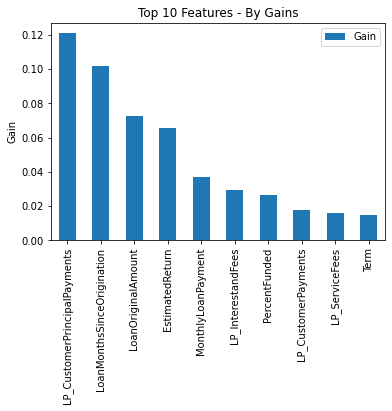

In [10]:
feature_importance_df = pd.DataFrame(best_model.feature_importances_, X_train.columns)
feature_importance_df.rename(columns={0:'Gain'}, inplace=True)
feature_importance_df.sort_values('Gain', ascending=False, inplace=True)
feature_importance_df[:10].plot(kind='bar')
plt.title('Top 10 Features - By Gains')
plt.ylabel('Gain')
plt.show()

#### Hyperparameter Tuning

In [ ]:
param_grid = {'max_depth':[6,9,12],
             'colsample_bytree': [0.3,0.4,0.5],
             'learning_rate':[0.2,0.3,0.4],
             'gamma':[0, 0.05, 0.1, 0.25],
             'reg_lambda':[0,1,2],
             'n_estimators':[300,600],
             'subsample':[0.3,0.4,0.5]}

In [12]:
clf_xgb = xgb.XGBClassifier(objective='binary:logistic', seed=123, eval_metric='aucpr', early_stopping=20)
randomized_auc = RandomizedSearchCV(estimator=clf_xgb, param_distributions=param_grid,
                                   scoring='roc_auc', n_iter=5, cv=10,  verbose=2, random_state=200)

In [13]:
start_time = time.time()
randomized_auc.fit(X_train,y_train)
end_time = time.time()

Fitting 10 folds for each of 5 candidates, totalling 50 fits
[CV] END colsample_bytree=0.4, gamma=0.05, learning_rate=0.3, max_depth=12, n_estimators=600, reg_lambda=1, subsample=0.4; total time=  50.8s
[CV] END colsample_bytree=0.4, gamma=0.05, learning_rate=0.3, max_depth=12, n_estimators=600, reg_lambda=1, subsample=0.4; total time=  52.9s
[CV] END colsample_bytree=0.4, gamma=0.05, learning_rate=0.3, max_depth=12, n_estimators=600, reg_lambda=1, subsample=0.4; total time=  53.8s
[CV] END colsample_bytree=0.4, gamma=0.05, learning_rate=0.3, max_depth=12, n_estimators=600, reg_lambda=1, subsample=0.4; total time=  53.5s
[CV] END colsample_bytree=0.4, gamma=0.05, learning_rate=0.3, max_depth=12, n_estimators=600, reg_lambda=1, subsample=0.4; total time=  51.7s
[CV] END colsample_bytree=0.4, gamma=0.05, learning_rate=0.3, max_depth=12, n_estimators=600, reg_lambda=1, subsample=0.4; total time=  51.8s
[CV] END colsample_bytree=0.4, gamma=0.05, learning_rate=0.3, max_depth=12, n_estimator

In [14]:
(end_time - start_time) / 60

34.05348307291667

In [15]:
best_model = randomized_auc.best_estimator_
best_model

XGBClassifier(base_score=0.5, booster='gbtree', callbacks=None,
              colsample_bylevel=1, colsample_bynode=1, colsample_bytree=0.4,
              early_stopping_rounds=None, enable_categorical=False,
              eval_metric='aucpr', gamma=0.05, gpu_id=-1,
              grow_policy='depthwise', importance_type=None,
              interaction_constraints='', learning_rate=0.3, max_bin=256,
              max_cat_to_onehot=4, max_delta_step=0, max_depth=12, max_leaves=0,
              min_child_weight=1, missing=nan, monotone_constraints='()',
              n_estimators=600, n_jobs=0, num_parallel_tree=1, predictor='auto',
              random_state=123, reg_alpha=0, reg_lambda=1, ...)

In [16]:
y_pred = best_model.predict(X_test)

In [17]:
model_scores(y_test, y_pred)

Model Results:
-------------------
Accuracy Score:  0.976689485694225
-------------------
ROC-AUC Score:  0.9337615209769278
-------------------
Confusion Matrix:
[[23674    40]
 [  624  4147]]
-------------------
Precision:  0.8692098092643051
-------------------
Recall:  0.990446620491999
-------------------
F1:  0.9258763116767136


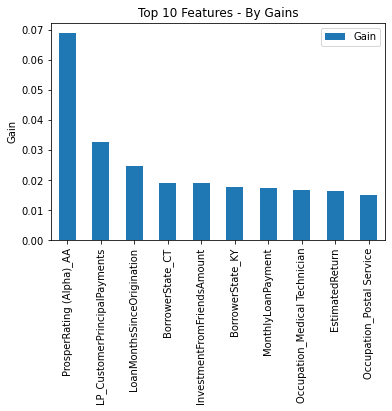

In [18]:
feature_importance_df = pd.DataFrame(best_model.feature_importances_, X_train.columns)
feature_importance_df.rename(columns={0:'Gain'}, inplace=True)
feature_importance_df.sort_values('Gain', ascending=False, inplace=True)
feature_importance_df[:10].plot(kind='bar')
plt.title('Top 10 Features - By Gains')
plt.ylabel('Gain')
plt.show()

## Model Evaluation and Next Steps

#### Initial Model

The initial model resulted in an accuracy score of 0.98, an AUC-ROC score of 0.944, a precision of 0.89, a recall of 0.99, and an f1 score of 0.94. The top features are principal customer payments, loan month since origination, original loan amount, estimated return, and monthly payments when ranked by gains.

#### Hyperparameter Tuning

I utilized the RandomizedSearchCV function from the sci-kit learn library to tune the various hyperparameter of the model. This method randomly selects hyperparameters from the input grid to test the selected metric through cross-validation. Since this method doesn't try every input from the parameter, it is faster than its counterpart GridSearchCV. I chose this method over the GridSearch method due to hardware and time limitations. However, the trade-off is that it might not find the most optimal set of parameters due to the randomness of the search method; this tuning took ~34 minutes to complete. After the hyperparameter tuning, the model returned an accuracy score of 0.978, an AUC-ROC score of 9.33, a precision of 0.87, a recall of 0.99, and an f1 score of 0.926. The top 5 features with the highest gains are Credit Rating AA, principal customer payments, loan month since origination, borrower state CT, and investment from friends account.

There are similarities in the top 5 features when ranked by gains. When comparing the graphs of the initial model and the tuned model, the initial model showed higher gains per feature. The results for the untuned model is better than the one chosen by randomized search. This signifies the best hyperparameter has not been found.

#### Model Limitations

The limitation of XGBoost models is the interpretability of the features. Unlike a basic decision tree with only one tree, XGBoost utilizes hundreds, if not thousands, of trees to optimize the prediction. So it's much more challenging to quantify the feature's importance. Therefore, I ordered them by how much "Gain" resulted from splitting each feature in this analysis. The resulting feature importance is shown in the bar graphs above.


#### Next Steps

The future plans for this project is to analysis every feature in depth and try different imputing methods and models to compare results. It will also be interesting run this model through GridSearchCV to find the most optimal hyper paramenter.